<a href="https://colab.research.google.com/github/MohammadKashif14/DocGPT/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from scipy import stats
from scipy.stats import randint
from scipy.stats import uniform

from warnings import filterwarnings
filterwarnings('ignore')

# Presets
%matplotlib inline
sns.set()

# Data Preprocessing and EDA


In [ ]:
data = pd.read_excel('/content/customer_churn_large_dataset.xlsx')

In [ ]:
data.head(5)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [ ]:
data.shape

(100000, 9)

In [ ]:
print(f"{len(data['CustomerID'].value_counts())},{len(data['Name'].value_counts())}")

100000,100000


* As we can see we have a unique customer in the given dataset. To identify the customer we can use either '**CustomerID**' or '**Name**'. Droping the '**Name**' column from DataFrame.

In [ ]:
data = data.drop(columns=['Name'])

In [ ]:
data.isnull().any()

CustomerID                    False
Age                           False
Gender                        False
Location                      False
Subscription_Length_Months    False
Monthly_Bill                  False
Total_Usage_GB                False
Churn                         False
dtype: bool

* Dataset doesn't contain any missing values.

In [ ]:
data.loc[:, 'Age':'Churn'].describe().T.style.bar(subset=['mean'], color='#206ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,100000.000000,44.027020,15.280283,18.000000,31.000000,44.000000,57.000000,70.000000
Subscription_Length_Months,100000.000000,12.490100,6.926461,1.000000,6.000000,12.000000,19.000000,24.000000
Monthly_Bill,100000.000000,65.053197,20.230696,30.000000,47.540000,65.010000,82.640000,100.000000
Total_Usage_GB,100000.000000,274.393650,130.463063,50.000000,161.000000,274.000000,387.000000,500.000000
Churn,100000.000000,0.497790,0.499998,0.000000,0.000000,0.000000,1.000000,1.000000


## Check the target variable

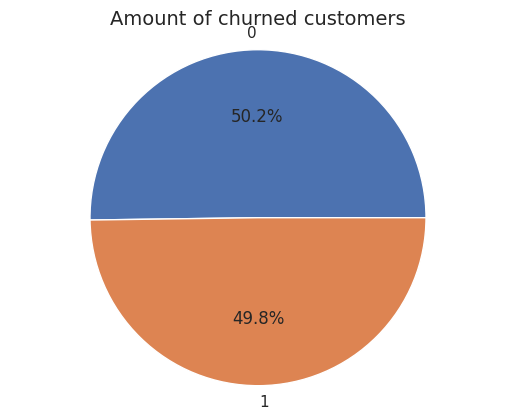

In [ ]:
target = data["Churn"].value_counts()

fig1, ax1 = plt.subplots()

ax1.pie(target, labels=target.index, autopct='%1.1f%%', shadow=None)
ax1.axis('equal')
plt.title("Amount of churned customers", fontsize=14)
plt.show()

* It is clear from the pie chart that approx 50% of the customers are "attrited" or "churned" and other pprox 50% stays. And clearlly we can say that we have a balanced data.

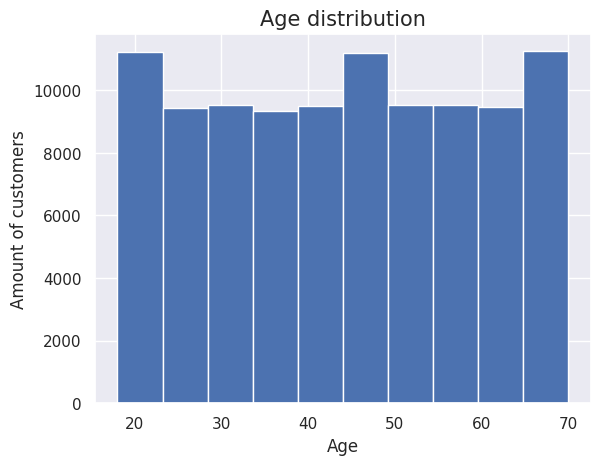

In [ ]:
data["Age"].hist()
plt.xlabel("Age")
plt.ylabel("Amount of customers")
plt.title("Age distribution", fontsize=15)
plt.show()

* The number of customers in 20's, above 40's and above 60's of age is more than 10000

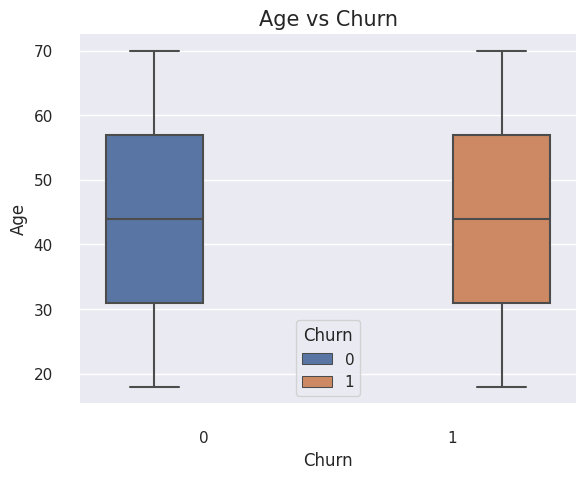

In [ ]:
sns.boxplot(x="Churn", y="Age",
            hue="Churn", palette=["b", "#DD8452"],
            data=data).set_title("Age vs Churn", fontsize=15)
sns.despine(offset=10, trim=True)

* The age is normally distributed. There is no clear difference between the age distribution.

In [ ]:
churned = data[data['Churn'] == 1]
nonchurned = data[data['Churn'] == 0]

def plot_pie(column):
    target = data[column].value_counts()
    fig1, ax1 = plt.subplots()
    ax1.pie(target, labels=target.index, autopct='%1.1f%%', shadow=None)
    ax1.axis('equal')
    plt.title("All customers", fontsize=14)
    plt.show()


def plot_compare(column, category_name):
    NChurned = len(churned[column].unique())
    NNonChurned = len(nonchurned[column].unique())

    ChurnedCounts = churned[column].value_counts().sort_index()
    NonChurnedCounts = nonchurned[column].value_counts().sort_index()

    indchurned = np.arange(NChurned)    # the x locations for the groups
    indnonchurned = np.arange(NNonChurned)
    width = 1       # the width of the bars: can also be len(x) sequence

    figs, axs = plt.subplots(1,2, figsize=(12,5))

    axs[1].bar(indchurned, ChurnedCounts, width, color='#DD8452')
    axs[1].set_title('Churned ' + category_name, fontsize=20)
    axs[1].set_xticks(indchurned)
    axs[1].set_xticklabels(ChurnedCounts.index.tolist(), rotation=45)

    axs[0].bar(indnonchurned, NonChurnedCounts, width, color='b')
    axs[0].set_title('Non Churned ' + category_name, fontsize=20)
    axs[0].set_ylabel('Amount of People')
    axs[0].set_xticks(indnonchurned)
    axs[0].set_xticklabels(NonChurnedCounts.index.tolist(), rotation=45)


    plt.show()

# Gender vs Churn

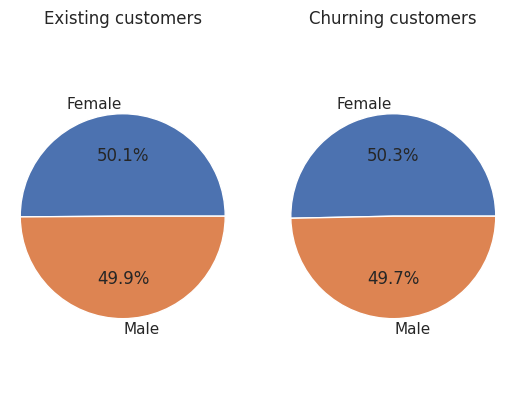

In [ ]:
churnedtarget = churned["Gender"].value_counts()
nonchurnedtarget = nonchurned["Gender"].value_counts()

fig1, axs = plt.subplots(1, 2)

axs[0].pie(churnedtarget, labels=churnedtarget.index, autopct='%1.1f%%', shadow=None)
axs[0].axis('equal')
axs[0].set_title('Existing customers')

axs[1].pie(nonchurnedtarget, labels=nonchurnedtarget.index, autopct='%1.1f%%', shadow=None)
axs[1].axis('equal')
axs[1].set_title('Churning customers')

plt.show()

* Male and Female have equal contribution in churning and staying

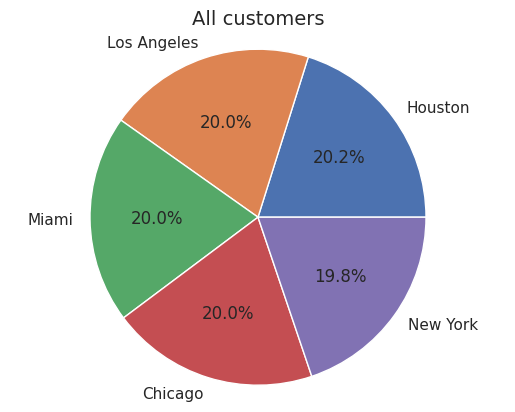

In [ ]:
plot_pie("Location")

* Each cities have approx same number of customers.

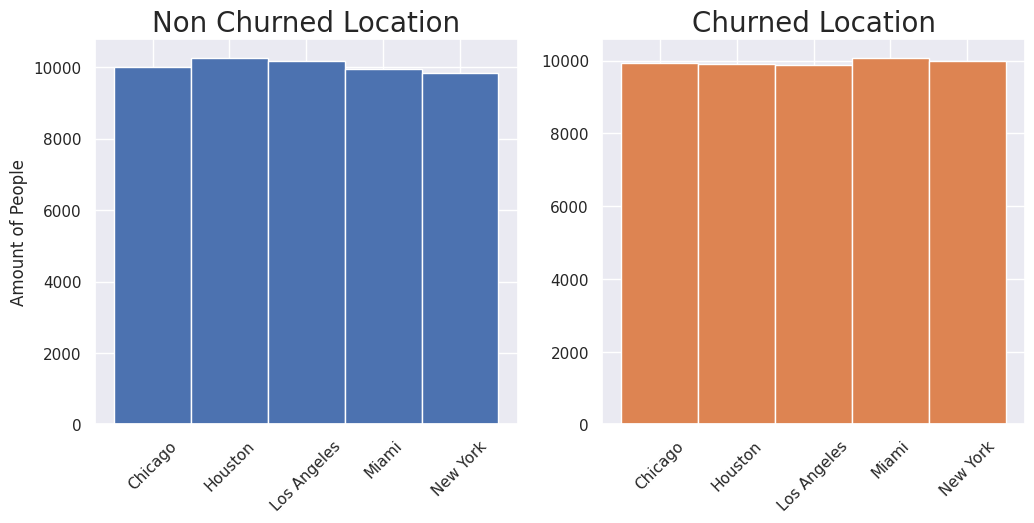

In [ ]:
plot_compare("Location", "Location")

* Each cities has approx equal number of customers in churning and non churning.

## Monthly Bill vs Churn

<Axes: xlabel='Churn', ylabel='Monthly_Bill'>

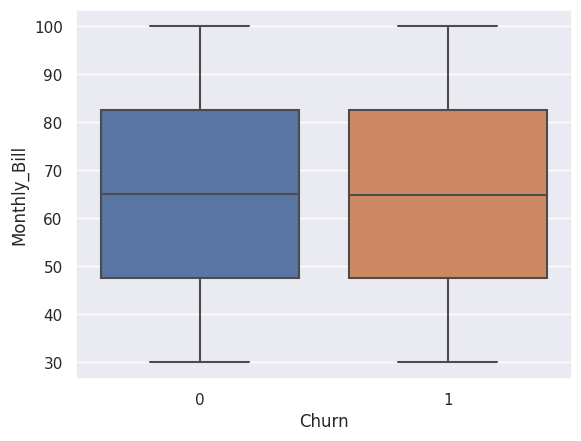

In [ ]:
sns.boxplot(x='Churn', y='Monthly_Bill', data=data)

* There is no relationship between bills and customer churn. Generally higher monthly bills lead to customer churn.

## Churn vs Subscription_Length_Months

<Axes: xlabel='Churn', ylabel='Subscription_Length_Months'>

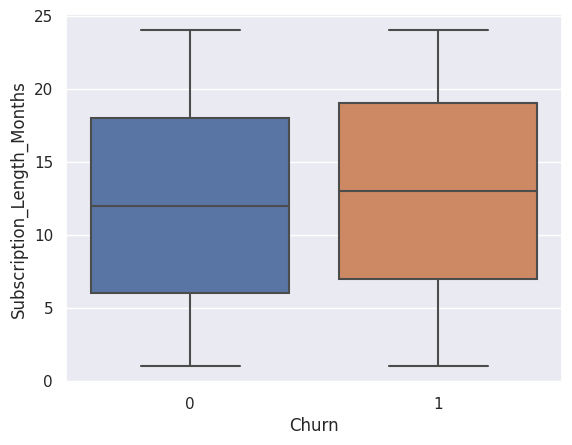

In [ ]:
sns.boxplot(x='Churn', y='Subscription_Length_Months', data=data)

* There seems a little trend that longer subscribed customer would likely churn.

## Churn vs Total_Usage_GB

<Axes: xlabel='Churn', ylabel='Total_Usage_GB'>

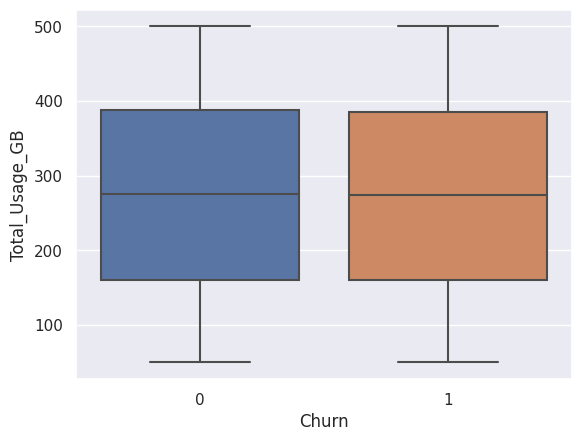

In [ ]:
sns.boxplot(x='Churn', y='Total_Usage_GB', data=data)

## Churn vs Categorical Variables

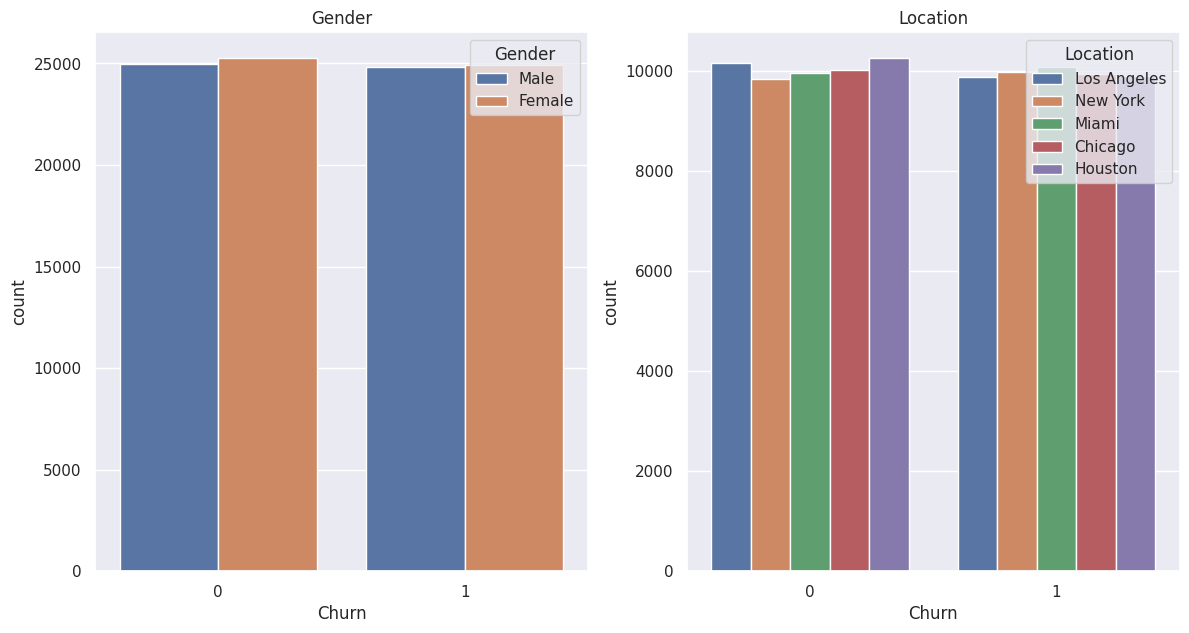

In [ ]:
cols = ['Gender', 'Location']
plt.figure(figsize=(14,7))

for i, col in enumerate(cols):
  ax = plt.subplot(1, len(cols), i+1)
  sns.countplot(x = "Churn", hue = str(col), data = data)
  ax.set_title(f"{col}")

## Detecting Outliers Using Z-Score

In [ ]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mn

def z_score(df, threshold=1):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df - mean) / std)
    good = z_score < threshold
    print(f"z-score of {threshold} corresponds to a prob of {100 * 2 * norm.sf(3):0.2f}%")
    print(f"Rejection {(~good).sum()} points")
    return good

In [ ]:
def outlierPlot(feature, train):

    plt.figure(figsize=(12, 8))

    for i, threshold in zip(range(1, 5), range(2, 6)):
        plt.subplot(2, 2, i)
        visual_scatter = np.random.normal(size=train.shape[0])
        good = z_score(train[feature], threshold=threshold)
        plt.scatter(train[feature][good], visual_scatter[good], s=10, label="Good", color="#4CAF50")
        plt.scatter(train[feature][~good], visual_scatter[~good], s=10, label="Bad", color="#F44336")
        plt.legend()
        plt.title(f"{feature} Outliers (threshold={threshold})")

    plt.tight_layout()

z-score of 2 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 0 points


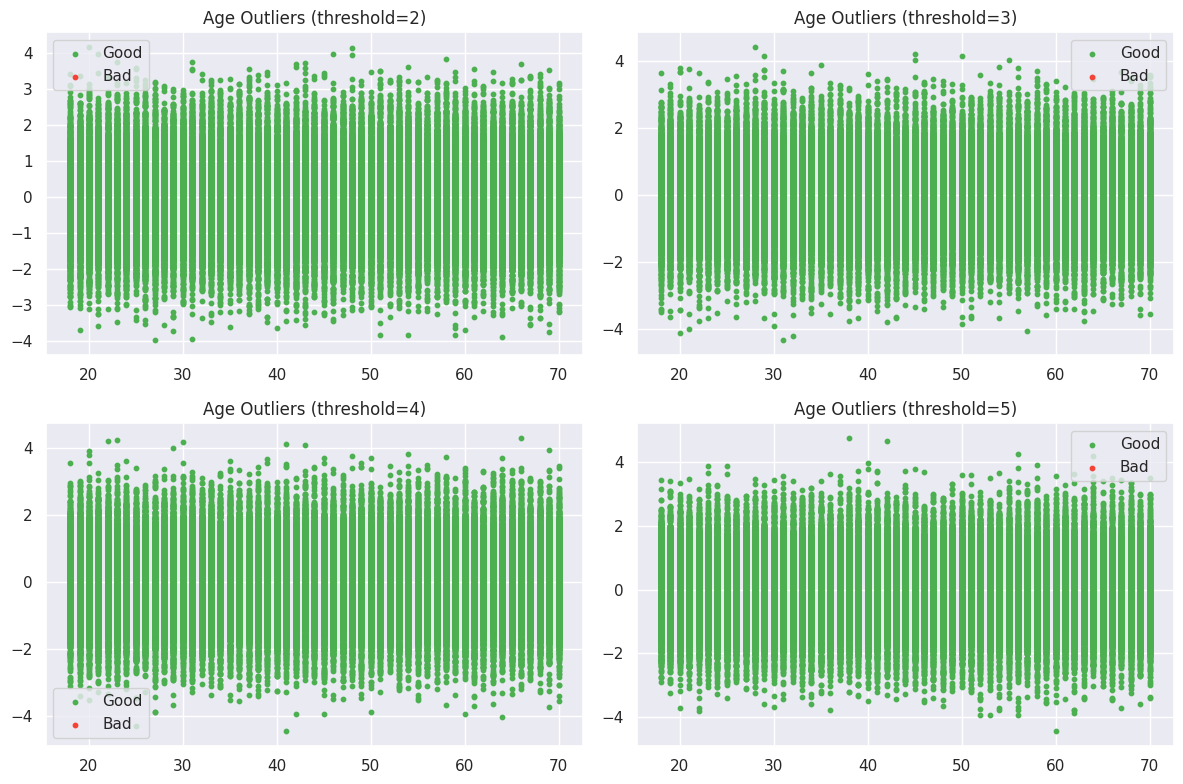

In [ ]:
outlierPlot('Age', data)

z-score of 2 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 0 points


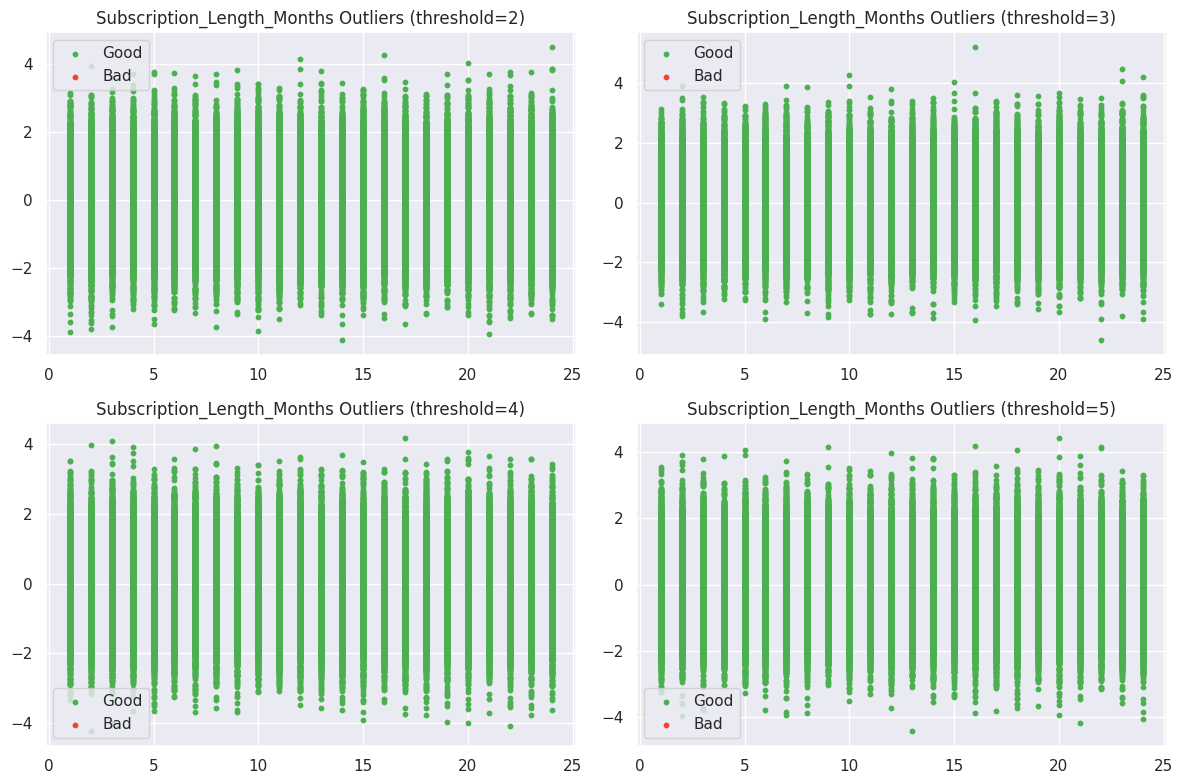

In [ ]:
outlierPlot('Subscription_Length_Months', data)

z-score of 2 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 0 points


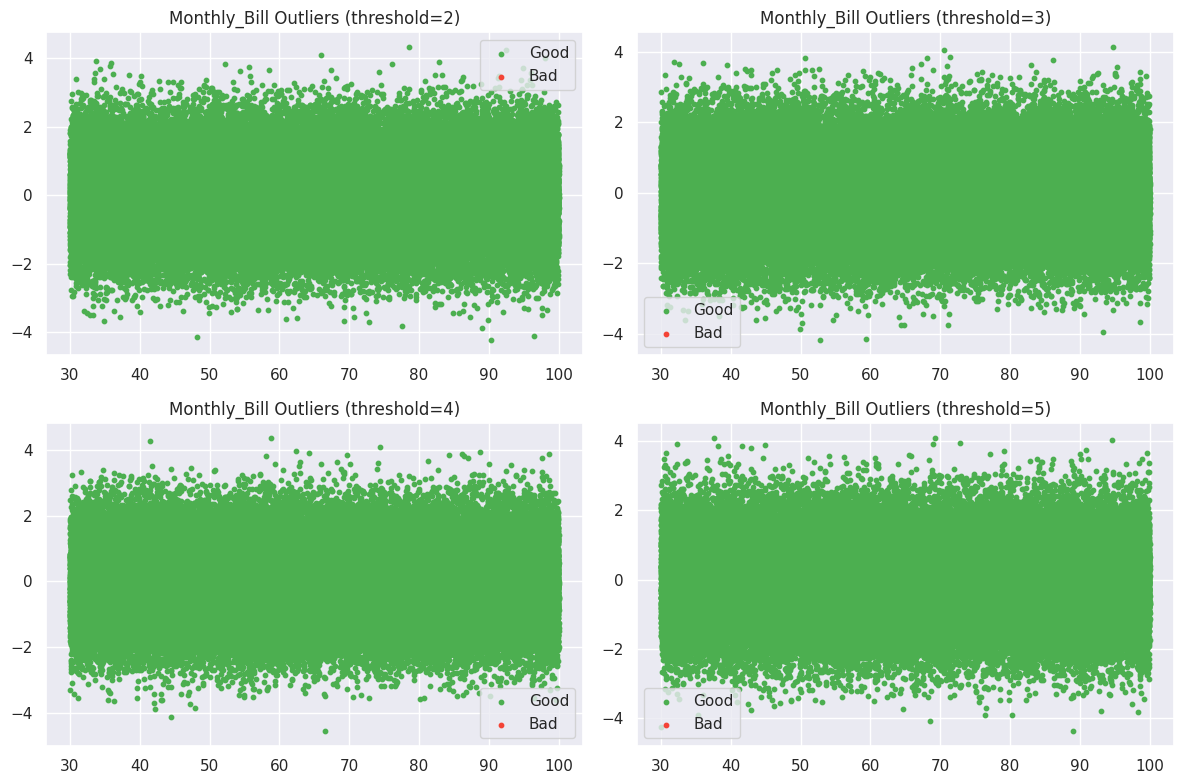

In [ ]:
outlierPlot('Monthly_Bill', data)

z-score of 2 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 3 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 4 corresponds to a prob of 0.27%
Rejection 0 points
z-score of 5 corresponds to a prob of 0.27%
Rejection 0 points


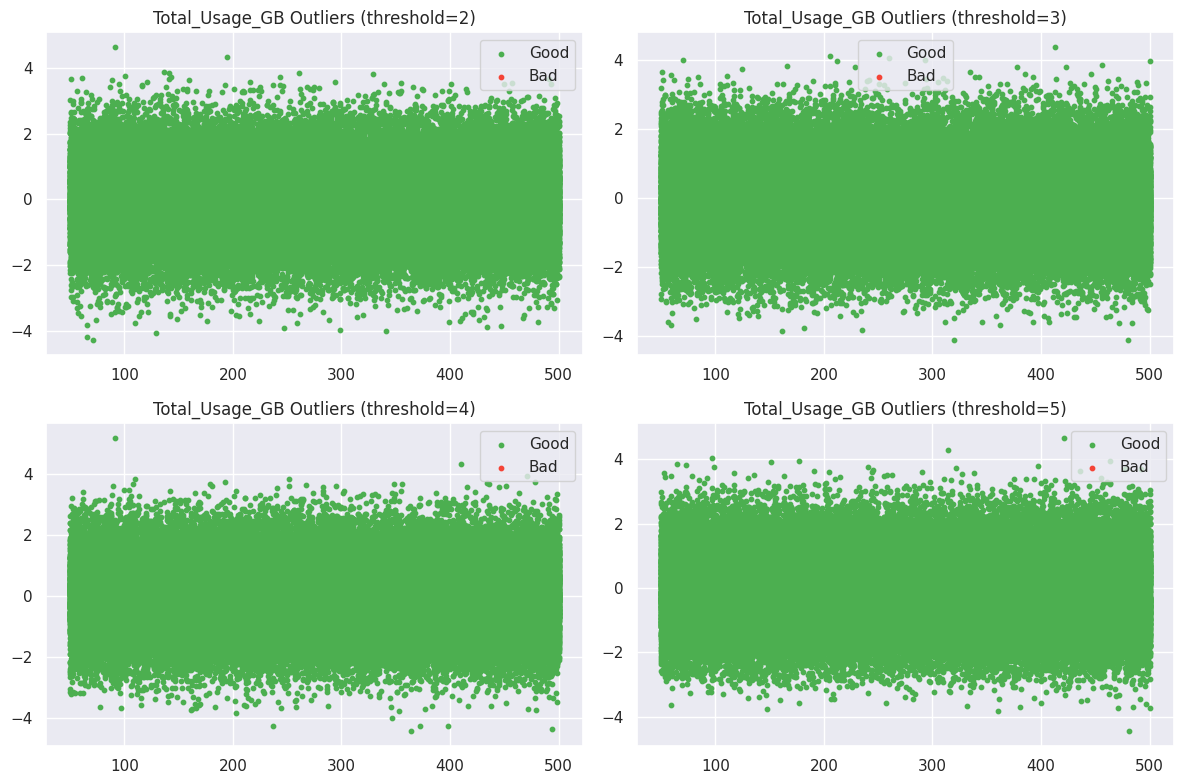

In [ ]:
outlierPlot('Total_Usage_GB', data)

* From the above graphs we can clearly say that numerical features doesn't contain outliers.

# Feature Engineering

Let's split the data into dependent and independent feature

In [ ]:
X = data.drop('Churn', axis=1).copy()
y = data['Churn']

In [ ]:
categorical_feature = ['Gender', 'Location']
numerical_feature   = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

#### Encoding Categorical Feature

In [ ]:
encoder = LabelEncoder()
for col in categorical_feature:
    encoder.fit(X[col])
    X[col] = encoder.transform(X[col])

In [ ]:
X.head()

,CustomerID,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB
0,1,63,1,2,17,73.36,236
1,2,62,0,4,1,48.76,172
2,3,24,0,2,5,85.47,460
3,4,36,0,3,3,97.94,297
4,5,46,0,3,19,58.14,266


In [ ]:
scaler = StandardScaler()
scaler.fit(X[numerical_feature])
X[numerical_feature] = scaler.transform(X[numerical_feature])

In [ ]:
X.head()

,CustomerID,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB
0,1,1.241670,1,2,0.651115,0.410606,-0.294289
1,2,1.176226,0,4,-1.658879,-0.805374,-0.784852
2,3,-1.310651,0,2,-1.081380,1.009204,1.422681
3,4,-0.525321,0,3,-1.370129,1.625597,0.173279
4,5,0.129120,0,3,0.939864,-0.341720,-0.064338


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Modelling

#### Logistic Regression

In [ ]:
lg = LogisticRegression(random_state=42)
lg.fit(X_train, y_train)

lgpreds = lg.predict(X_test)
print(classification_report(y_test, lgpreds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     15081
           1       0.00      0.00      0.00     14919

    accuracy                           0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.34     30000



#### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rfpred = rf.predict(X_test)
print(classification_report(y_test, rfpred))

              precision    recall  f1-score   support

           0       0.50      0.53      0.51     15081
           1       0.49      0.46      0.48     14919

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



#### XGBClassifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgbpred = xgb.predict(X_test)
print(classification_report(y_test, xgbpred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51     15081
           1       0.49      0.47      0.48     14919

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



In [ ]:
ypred = xgbpred
model = xgb
print ('Confusion Matrix:')
print(confusion_matrix(y_test, ypred))
print('\nAccuracy:', accuracy_score(y_test, ypred))
print("Overall Precision:",precision_score(y_test, ypred))
print("Overall Recall:",recall_score(y_test, ypred))
print("Overall f1-score:", f1_score(y_test, ypred))
auc = roc_auc_score(y_test,ypred)
plt.show()

Confusion Matrix:
[[7899 7182]
 [7881 7038]]

Accuracy: 0.4979
Overall Precision: 0.49493670886075947
Overall Recall: 0.4717474361552383
Overall f1-score: 0.4830639349325646


# Hyperparameter Tuning

* I am going to use optuna for this task

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.8 MB/s eta 0:00:00


In [ ]:
import optuna
def objective(trial,data=X,target=y):

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=42)

    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400),
        'eta': trial.suggest_float('eta', 0.007, 0.013),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'predictor': "gpu_predictor",
        'eval_metric' : 'auc',
        'objective' : 'binary:logistic',
        }

    model = XGBClassifier(**params, tree_method='gpu_hist', random_state=2021, use_label_encoder=False)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)

    preds = model.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(test_y, preds)
    score = auc(fpr, tpr)

    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-09-05 04:24:29,599] A new study created in memory with name: no-name-82480cc7-145c-4200-9d85-b42536c6dab9
[I 2023-09-05 04:24:30,617] Trial 0 finished with value: 0.5015179747368033 and parameters: {'max_depth': 6, 'n_estimators': 3600, 'eta': 0.009798643080443124, 'subsample': 0.4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 0.6922230941922287, 'reg_lambda': 2.618729488482886, 'reg_alpha': 2.914394115578732, 'gamma': 0.944061519786657}. Best is trial 0 with value: 0.5015179747368033.
[I 2023-09-05 04:24:31,563] Trial 1 finished with value: 0.5085341576167769 and parameters: {'max_depth': 7, 'n_estimators': 2400, 'eta': 0.012655566937532291, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 3.0050986030832756, 'reg_lambda': 0.917902555328403, 'reg_alpha': 0.01890050762020562, 'gamma': 0.0002890314793948051}. Best is trial 1 with value: 0.5085341576167769.
[I 2023-09-05 04:24:31,870] Trial 2 finish

Number of finished trials: 100
Best trial: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.012262114216112795, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 177.26290313325472, 'reg_lambda': 0.45828664799296553, 'reg_alpha': 0.04381215159806593, 'gamma': 0.36987821603570936}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
params=study.best_params
print(params)

{'max_depth': 6, 'n_estimators': 3200, 'eta': 0.012262114216112795, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 177.26290313325472, 'reg_lambda': 0.45828664799296553, 'reg_alpha': 0.04381215159806593, 'gamma': 0.36987821603570936}


#### Cross Validation and Modelling

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

preds = []
scores = []

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = XGBClassifier(**params,
                              booster= 'gbtree',
                              eval_metric = 'auc',
                              tree_method= 'gpu_hist',
                              predictor="gpu_predictor",
                              )
    model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=False)

    pred_valid = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)

    print(f"Fold: {fold + 1} Score: {score}")
    print('||'*20)

    test_preds = model.predict_proba(X_test)[:,1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.49840170263447836
||||||||||||||||||||||||||||||||||||||||
Fold: 2 Score: 0.4945696698688086
||||||||||||||||||||||||||||||||||||||||
Fold: 3 Score: 0.509054215289608
||||||||||||||||||||||||||||||||||||||||
Fold: 4 Score: 0.5000123752395846
||||||||||||||||||||||||||||||||||||||||
Fold: 5 Score: 0.4949337069165659
||||||||||||||||||||||||||||||||||||||||
Overall Validation Score: 0.4993943339898091
CPU times: user 33 s, sys: 238 ms, total: 33.2 s
Wall time: 32.3 s


# Neural Network Using Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

In [ ]:
class CustomDataset:

    def __init__(self, data, target=None):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if self.target is not None:
            current_sample = self.data.values[idx]
            current_target = self.target.values[idx]

            return torch.tensor(current_sample, dtype= torch.float), torch.tensor(current_target, dtype= torch.float)
        else:
            current_sample = self.data.values[idx]
            return torch.tensor(current_sample, dtype= torch.float)

In [ ]:
class NNModel(nn.Module):
    def __init__(self, features, activation = F.relu):
        super(NNModel, self).__init__()

        """Number of input is no of features(6)"""
        self.layer_1 = nn.Linear(features, 32)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.layer_2 = nn.Linear(32, 16)
        self.batchnorm2 = nn.BatchNorm1d(16)
        self.layer_out = nn.Linear(16,1)
        self.flatten = nn.Flatten()
        self.activation = activation

    def forward(self, x):
        x = self.flatten(x)
        x = self.batchnorm1(self.activation(self.layer_1(x)))
        x = self.batchnorm2(self.activation(self.layer_2(x)))
        x = torch.sigmoid(self.layer_out(x))

        return torch.squeeze(x, dim=1)

In [ ]:
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data, nonlinearity="relu")

            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)

In [ ]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 1024
features = X.columns

In [ ]:
def train_model(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batches = len(dataloader)
    train_loss = 0

    for batch_idx, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        scores = model(X)
        loss = criterion(scores, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        train_loss += loss

    train_loss_avg = train_loss/batches
    print(f"avg. train loss: {train_loss_avg}")
    return train_loss_avg

In [ ]:
def val_model(dataloader, model, criterion):

    size= len(dataloader.dataset)
    batches= len(dataloader)
    model.eval()
    test_loss= 0

    with torch.no_grad():
        for X, y in (dataloader):
            X, y= X.to(device), y.to(device)

            scores= model(X)
            test_loss += criterion(scores, y)

    test_loss /= batches
    print(f"avg test loss : {test_loss}")
    return test_loss

In [ ]:
def predict_model(dataloader, model):
    model.eval()
    y_pred= np.array([])

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)

            preds= model(X)
            preds= preds.flatten().cpu().numpy()

            y_pred= np.concatenate((y_pred, preds))

    return y_pred

Epoch: 1
avg. train loss: 0.7155201570897163
avg test loss : 17.425457000732422
Epoch: 2
avg. train loss: 0.6951796027678477
avg test loss : 10.196860313415527
Epoch: 3
avg. train loss: 0.6939736883851546
avg test loss : 9.576692581176758
Epoch: 4
avg. train loss: 0.6937162212178677
avg test loss : 8.64846134185791
Epoch: 5
avg. train loss: 0.6935202592535864
avg test loss : 9.564948081970215
Fold: 1 Loss: 11.082484245300293


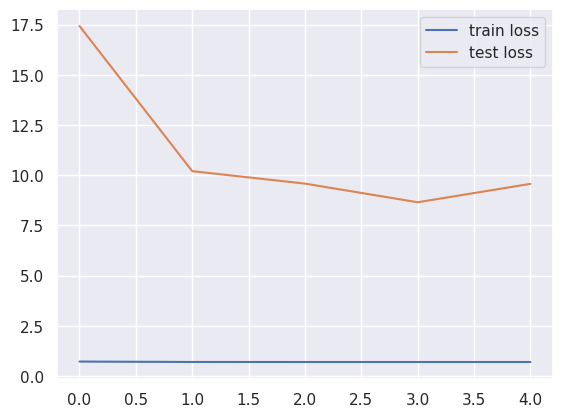

Epoch: 1
avg. train loss: 0.698154061655455
avg test loss : 18.033048629760742
Epoch: 2
avg. train loss: 0.6937633466116989
avg test loss : 14.861556053161621
Epoch: 3
avg. train loss: 0.693503356432613
avg test loss : 14.139472007751465
Epoch: 4
avg. train loss: 0.693367959577826
avg test loss : 17.48221206665039
Epoch: 5
avg. train loss: 0.6932601430748082
avg test loss : 18.441843032836914
Fold: 2 Loss: 16.591625213623047


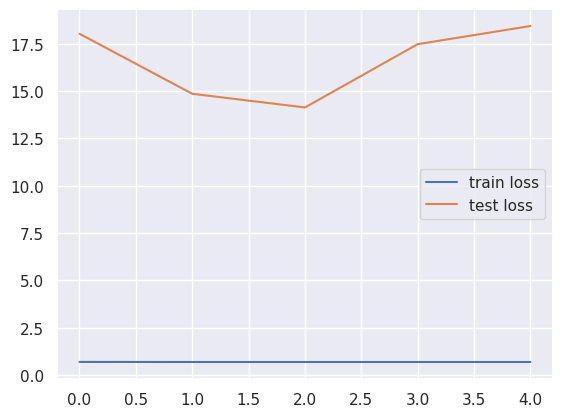

Epoch: 1
avg. train loss: 0.7403966482681564
avg test loss : 33.2379035949707
Epoch: 2
avg. train loss: 0.6947960921480686
avg test loss : 1.965448021888733
Epoch: 3
avg. train loss: 0.6943419658685033
avg test loss : 1.328766942024231
Epoch: 4
avg. train loss: 0.6941092052037203
avg test loss : 1.345476508140564
Epoch: 5
avg. train loss: 0.6939186732980269
avg test loss : 1.7386211156845093
Fold: 3 Loss: 7.923243045806885


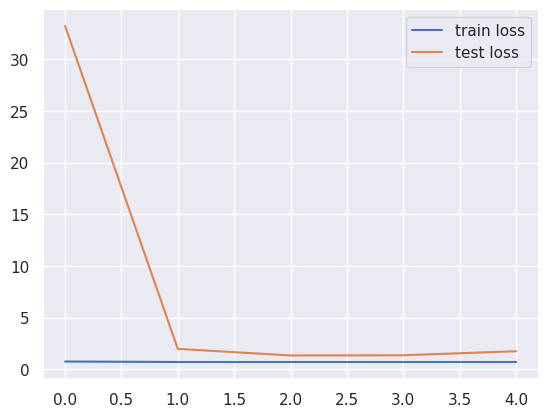

Epoch: 1
avg. train loss: 0.7616782346858254
avg test loss : 4.737797260284424
Epoch: 2
avg. train loss: 0.6957261592526979
avg test loss : 2.339681386947632
Epoch: 3
avg. train loss: 0.6951418541654756
avg test loss : 0.9522695541381836
Epoch: 4
avg. train loss: 0.6948919620694993
avg test loss : 0.8673660159111023
Epoch: 5
avg. train loss: 0.694758004025568
avg test loss : 0.7273684740066528
Fold: 4 Loss: 1.924896478652954


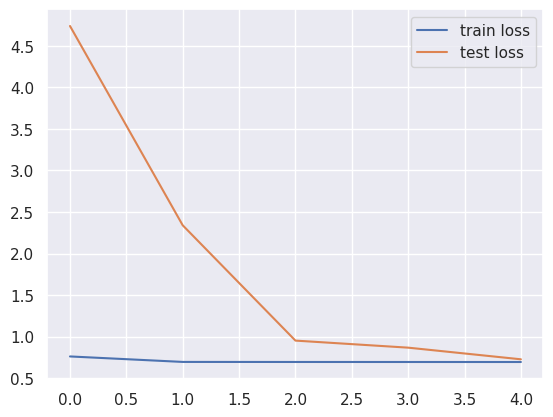

Epoch: 1
avg. train loss: 0.7030023313775847
avg test loss : 5.421976089477539
Epoch: 2
avg. train loss: 0.6937217968928663
avg test loss : 6.666194438934326
Epoch: 3
avg. train loss: 0.6934101430675651
avg test loss : 5.545020580291748
Epoch: 4
avg. train loss: 0.6932668104956422
avg test loss : 5.6017889976501465
Epoch: 5
avg. train loss: 0.6931243440772914
avg test loss : 5.197598934173584
Fold: 5 Loss: 5.686516284942627


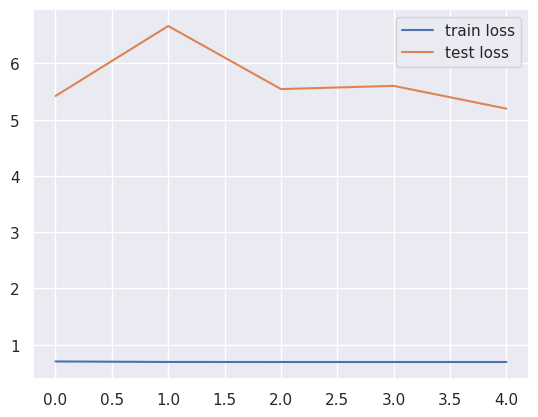

In [ ]:
KFold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
EPOCHS = 5
cv_scores = []
predictions = np.zeros(X_test.shape[0])

for fold, (train_idx, val_idx) in enumerate(KFold.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = CustomDataset(data=X_train, target=y_train)
    val_dataset = CustomDataset(data=X_val, target=y_val)

    train_loader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE)
    val_loader = data.DataLoader(val_dataset, batch_size = BATCH_SIZE)

    model = NNModel(features=len(features), activation=F.relu).to(device)
    model.apply(initialize_weights)

    criterion = nn.BCELoss()
    criterion.to(device)

    optimizer= optim.Adam(model.parameters(), lr= 0.001)
    scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    factor= 0.5,
                                                    patience= 10,
                                                    verbose= True)
    best_valid_loss= float('inf')

    avg_train_losses= []
    avg_val_losses= []

    for t in range(EPOCHS):
        print(f"Epoch: {t+1}")
        train_loss= train_model(train_loader, model, criterion, optimizer)
        val_loss= val_model(val_loader, model, criterion)

        train_loss = torch.tensor(train_loss)
        val_loss   = torch.tensor(val_loss)

        avg_train_losses.append(train_loss.detach().cpu().numpy())
        avg_val_losses.append(val_loss.detach().cpu().numpy())

        if (val_loss < best_valid_loss):
            best_valid_loss= val_loss
            ofilename = 'churn%d.pth' % fold
            torch.save(model.state_dict(),  ofilename)

        scheduler.step(val_loss)
    cv_scores.append(best_valid_loss)

    print(f"Fold: {fold + 1} Loss: {np.mean(avg_val_losses)}")
    plt.plot(avg_train_losses, label='train loss')
    plt.plot(avg_val_losses, label='test loss')
    plt.legend()
    plt.show()